In [1]:
import json
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt

In [2]:
root_directory_for_pbns = (
    "/scratch/zhivar/robust-prototype-learning/PBN_transformer/summaries"
)

root_directory_for_normal_models = (
    "/scratch/zhivar/robust-prototype-learning/datasets/summaries"
)

In [3]:
def get_attack_type(file_path):
    for attack_type in ["textfooler", "textbugger", "deepwordbug", "pwws", "bae"]:
        if attack_type.lower() in file_path.lower():
            return attack_type
    raise ValueError(f"Unknown attack type for file {file_path}")


def get_classifier_model(file_path):
    for classifier in [
        "electra-base-discriminator",
        "bart-base-mnli",
        "bert-medium",
        "electra",
        "bert",
        "bart",
    ]:
        if classifier.lower() in file_path.lower():
            return classifier.split("-")[0]
    return "bart"


def get_dataset(file_path):
    for dataset in ["imdb", "sst2", "ag_news", "dbpedia"]:
        if dataset.lower() in file_path.lower():
            return dataset
    raise ValueError(f"Unknown dataset for file {file_path}")


def get_the_hyperparameters(file_path):
    dictionary_to_correct_values = {
        0: 0.0,
        9: 0.9,
        100: 10.0,
        2: 2,
        4: 4,
        8: 8,
        16: 16,
        64: 64,
    }
    pattern_to_look_for = re.compile(r".*_(\d+)\_(\d+)\_(\d+)\_(\d+).*")
    second_pattern_to_look_for = re.compile(r".*_(\d+)_(\d+)_(\d+).*")

    matched_integers = re.match(pattern_to_look_for, file_path)
    if matched_integers:
        return [dictionary_to_correct_values[int(x)] for x in matched_integers.groups()]
    else:
        matched_integers = re.match(second_pattern_to_look_for, file_path)
        if matched_integers:
            return [
                dictionary_to_correct_values[int(x)]
                for x in (*matched_integers.groups(), 16)
            ]
    raise ValueError(f"Could not find hyperparameters for file {file_path}")

In [4]:
random_file_name_1 = "summary_ag_news_textbugger_BERT_ag_news_model_09_09_09_4.json"
random_file_name_2 = "summary_ag_news_textbugger_ag_news_model_09_09_09_ELECTRA.json"
random_file_name_3 = "summary_ag_news_textfooler_BERT_ag_news_model_09_100_09_16.json"
random_file_name_4 = "summary_imdb_deepwordbug_ELECTRA_imdb_model_100_09_09_16.json"

for file_name in [
    random_file_name_1,
    random_file_name_2,
    random_file_name_3,
    random_file_name_4,
]:
    print(get_the_hyperparameters(file_name))

[0.9, 0.9, 0.9, 4]
[0.9, 0.9, 0.9, 16]
[0.9, 10.0, 0.9, 16]
[10.0, 0.9, 0.9, 16]


In [5]:
def process_file_pbn(log_file, root_directory):
    with open(os.path.join(root_directory, log_file), "r") as f:
        data = json.load(f)
        f.close()
    if "result" in data.keys():
        data_object = {
            "file_path": log_file,
            "attack_type": get_attack_type(log_file),
            "classifier_model": get_classifier_model(log_file),
            "dataset": get_dataset(log_file),
            "hyperparameters": get_the_hyperparameters(log_file),
            "comment": data["result"],
        }
    else:
        data = data["Attack Results"]
        data_object = {
            "file_path": log_file,
            "attack_type": get_attack_type(log_file),
            "classifier_model": get_classifier_model(log_file),
            "dataset": get_dataset(log_file),
            "hyperparameters": get_the_hyperparameters(log_file),
            "Number of successful attacks:": data["Number of successful attacks:"],
            "Number of failed attacks:": data["Number of failed attacks:"],
            "Number of skipped attacks:": data["Number of skipped attacks:"],
            "Original accuracy:": data["Original accuracy:"],
            "Accuracy under attack:": data["Accuracy under attack:"],
            "Attack success rate:": data["Attack success rate:"],
            "Average perturbed word %:": data["Average perturbed word %:"],
            "Average num. words per input:": data["Average num. words per input:"],
            "Avg num queries:": data["Avg num queries:"],
            "comment": "successful",
        }
    return data_object

In [6]:
all_log_files = [
    file for file in os.listdir(root_directory_for_pbns) if file.startswith("summary_")
]

all_data_objects = []

for log_file in all_log_files:
    try:
        data_object = process_file_pbn(log_file, root_directory_for_pbns)
        all_data_objects.append(data_object)
    except Exception as e:
        print(e)
        break

results_df_pbn = pd.DataFrame(all_data_objects)
results_df_pbn

Expecting value: line 1 column 1 (char 0)


,file_path,attack_type,classifier_model,dataset,hyperparameters,Number of successful attacks:,Number of failed attacks:,Number of skipped attacks:,Original accuracy:,Accuracy under attack:,Attack success rate:,Average perturbed word %:,Average num. words per input:,Avg num queries:,comment
0,summary_imdb_textfooler_imdb_model_09_09_09.json,textfooler,bart,imdb,"[0.9, 0.9, 0.9, 16]",800.0,106.0,71.0,92.73,10.85,88.30,12.13,230.47,1035.63,successful
1,summary_dbpedia_textfooler_dbpedia_model_09_09...,textfooler,bart,dbpedia,"[0.9, 0.9, 0.9, 16]",800.0,700.0,9.0,99.40,46.39,53.33,25.99,103.83,918.13,successful
2,summary_imdb_textbugger_imdb_model_09_09_09.json,textbugger,bart,imdb,"[0.9, 0.9, 0.9, 16]",800.0,1020.0,128.0,93.43,52.36,43.96,28.40,227.61,662.42,successful
3,summary_ag_news_textfooler_ag_news_model_09_09...,textfooler,bart,ag_news,"[0.9, 0.9, 0.9, 16]",800.0,487.0,119.0,91.54,34.64,62.16,24.11,37.93,385.60,successful
4,summary_ag_news_textbugger_ag_news_model_09_09...,textbugger,bart,ag_news,"[0.9, 0.9, 0.9, 16]",800.0,2456.0,274.0,92.24,69.58,24.57,30.61,38.32,184.35,successful
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,summary_ag_news_bae_BART_ag_news_model_09_09_0...,bae,bart,ag_news,"[0.9, 0.9, 0.9, 2]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This model is not accurate enough in the first...
390,summary_ag_news_bae_BART_ag_news_model_09_100_...,bae,bart,ag_news,"[0.9, 10.0, 0.9, 16]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This model is not accurate enough in the first...
391,summary_ag_news_bae_BART_ag_news_model_00_09_0...,bae,bart,ag_news,"[0.0, 0.9, 0.9, 16]",800.0,4608.0,505.0,91.46,77.93,14.79,9.01,38.56,114.31,successful
392,summary_ag_news_bae_BART_ag_news_model_100_09_...,bae,bart,ag_news,"[10.0, 0.9, 0.9, 16]",800.0,4708.0,532.0,91.19,77.95,14.52,8.16,38.58,117.24,successful


In [7]:
def is_attacked_normal_model(file_path):
    for classifier in [
        "electra-base-discriminator",
        "bart-base-mnli",
        "bert-medium",
    ]:
        if classifier.lower() in file_path.lower():
            return True
    return False

In [8]:
def process_file_non_pbn(log_file, root_directory):
    with open(os.path.join(root_directory, log_file), "r") as f:
        data = json.load(f)
        f.close()

    data = data["Attack Results"]
    data_object = {
        "file_path": log_file,
        "attack_type": get_attack_type(log_file),
        "classifier_model": get_classifier_model(log_file),
        "dataset": get_dataset(log_file),
        "hyperparameters": None,
        "Number of successful attacks:": data["Number of successful attacks:"],
        "Number of failed attacks:": data["Number of failed attacks:"],
        "Number of skipped attacks:": data["Number of skipped attacks:"],
        "Original accuracy:": data["Original accuracy:"],
        "Accuracy under attack:": data["Accuracy under attack:"],
        "Attack success rate:": data["Attack success rate:"],
        "Average perturbed word %:": data["Average perturbed word %:"],
        "Average num. words per input:": data["Average num. words per input:"],
        "Avg num queries:": data["Avg num queries:"],
        "comment": "successful",
    }
    return data_object

In [9]:
all_log_files = [
    file
    for file in os.listdir(root_directory_for_normal_models)
    if file.startswith("summary_")
]

all_data_objects = []

for log_file in all_log_files:
    if not is_attacked_normal_model(log_file):
        continue
    try:
        data_object = process_file_non_pbn(log_file, root_directory_for_normal_models)
        all_data_objects.append(data_object)
    except Exception as e:
        print(e)
        break

results_df_non_pbns = pd.DataFrame(all_data_objects)
results_df_non_pbns.head(3)

,file_path,attack_type,classifier_model,dataset,hyperparameters,Number of successful attacks:,Number of failed attacks:,Number of skipped attacks:,Original accuracy:,Accuracy under attack:,Attack success rate:,Average perturbed word %:,Average num. words per input:,Avg num queries:,comment
0,summary_imdb_textfooler__normal_models_models_...,textfooler,bart,imdb,None,800,0,73,91.64,0.00,100.00,5.92,231.20,442.62,successful
1,summary_imdb_textbugger__normal_models_models_...,textbugger,bart,imdb,None,800,219,85,92.30,19.84,78.51,33.32,230.43,428.52,successful
2,summary_ag_news_textfooler__normal_models_mode...,textfooler,bart,ag_news,None,800,246,93,91.83,21.60,76.48,25.00,37.90,333.32,successful


In [10]:
results_df_pbn = results_df_pbn[results_df_pbn["comment"] == "successful"]
results_df_pbn["comment"] = "PBN"
results_df_non_pbns["comment"] = "non_PBN"

/tmp/ipykernel_81415/3444515158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_pbn["comment"] = "PBN"


In [11]:
results_df_merged = pd.concat([results_df_pbn, results_df_non_pbns])
results_df_merged.head(3)

,file_path,attack_type,classifier_model,dataset,hyperparameters,Number of successful attacks:,Number of failed attacks:,Number of skipped attacks:,Original accuracy:,Accuracy under attack:,Attack success rate:,Average perturbed word %:,Average num. words per input:,Avg num queries:,comment
0,summary_imdb_textfooler_imdb_model_09_09_09.json,textfooler,bart,imdb,"[0.9, 0.9, 0.9, 16]",800.0,106.0,71.0,92.73,10.85,88.30,12.13,230.47,1035.63,PBN
1,summary_dbpedia_textfooler_dbpedia_model_09_09...,textfooler,bart,dbpedia,"[0.9, 0.9, 0.9, 16]",800.0,700.0,9.0,99.40,46.39,53.33,25.99,103.83,918.13,PBN
2,summary_imdb_textbugger_imdb_model_09_09_09.json,textbugger,bart,imdb,"[0.9, 0.9, 0.9, 16]",800.0,1020.0,128.0,93.43,52.36,43.96,28.40,227.61,662.42,PBN


In [12]:
attack_success_rate_summary_results = (
    results_df_merged.groupby(["dataset", "classifier_model", "attack_type"])
    .apply(
        lambda x: (
            x[x["comment"] == "PBN"]["Attack success rate:"].mean(),
            x[x["comment"] == "non_PBN"]["Attack success rate:"].mean(),
        )
    )
    .reset_index()
    .rename(columns={0: "Attack success rate"})
)
print(
    "The rate at which the PBN model attack success rate is lower than non PBN model attack success rate",
    attack_success_rate_summary_results[
        attack_success_rate_summary_results["Attack success rate"].apply(
            lambda x: x[0] < x[1]
        )
    ].shape[0]
    / attack_success_rate_summary_results.shape[0],
)
attack_success_rate_summary_results.head(3)

The rate at which the PBN model attack success rate is lower than non PBN model attack success rate 0.8222222222222222


,dataset,classifier_model,attack_type,Attack success rate
0,ag_news,bart,bae,"(14.993333333333332, 14.82)"
1,ag_news,bart,deepwordbug,"(41.22222222222222, 53.16)"
2,ag_news,bart,pwws,"(51.760000000000005, 53.62)"


In [13]:
results_df_pbn["p1_lamb"] = results_df_pbn["hyperparameters"].apply(lambda x: x[0])
results_df_pbn["p2_lamb"] = results_df_pbn["hyperparameters"].apply(lambda x: x[1])
results_df_pbn["p3_lamb"] = results_df_pbn["hyperparameters"].apply(lambda x: x[2])
results_df_pbn["num_proto"] = results_df_pbn["hyperparameters"].apply(lambda x: x[3])

/tmp/ipykernel_81415/2201319661.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_pbn["p1_lamb"] = results_df_pbn["hyperparameters"].apply(lambda x: x[0])
/tmp/ipykernel_81415/2201319661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_pbn["p2_lamb"] = results_df_pbn["hyperparameters"].apply(lambda x: x[1])
/tmp/ipykernel_81415/2201319661.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

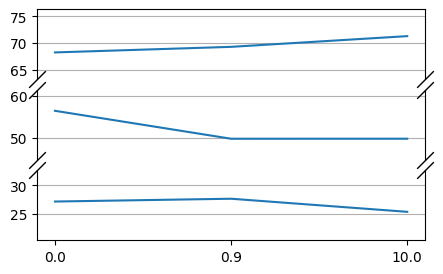

In [47]:
fig, axs = plt.subplots(3, 1, figsize=(5, 3), sharex=True)
for ax, dataset in zip(axs, ["imdb", "ag_news", "dbpedia"]):
    sub_df = results_df_pbn[results_df_pbn["dataset"] == dataset]
    results = sub_df.groupby("p1_lamb")["Attack success rate:"].mean()
    x = results.index
    y = results.values

    ax.plot(range(len(x)), y, label="Attack success rate")
    ax.set_ylim(min(y) - 5, max(y) + 5)
    ax.grid(axis="y")
    ax.set_xticks(range(len(x)))
    ax.set_xticklabels(x)

# remove the spines between the plots
axs[0].spines["bottom"].set_visible(False)
axs[1].spines["top"].set_visible(False)
axs[1].spines["bottom"].set_visible(False)
axs[2].spines["top"].set_visible(False)
# remove the xaxis for all but the bottom plot
axs[0].xaxis.set_visible(False)
axs[1].xaxis.set_visible(False)

# plt.xlabel("p1_lamb")
# plt.ylabel("Attack success rate (%)")
d = 1.0  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(
    marker=[(-1, -d), (1, d)],
    markersize=12,
    linestyle="none",
    color="k",
    mec="k",
    mew=1,
    clip_on=False,
)

axs[0].plot([0, 1], [0, 0], transform=axs[0].transAxes, **kwargs)
axs[1].plot([0, 1], [1, 1], transform=axs[1].transAxes, **kwargs)
axs[1].plot([0, 1], [0, 0], transform=axs[1].transAxes, **kwargs)
axs[2].plot([0, 1], [1, 1], transform=axs[2].transAxes, **kwargs)

# reduce the space between the plots
fig.subplots_adjust(hspace=0.15)
plt.show()

In [17]:
average_perturbed_word_summary_results = (
    results_df_merged.groupby(["dataset", "classifier_model", "attack_type"])
    .apply(
        lambda x: (
            x[x["comment"] == "PBN"]["Average perturbed word %:"].mean(),
            x[x["comment"] == "non_PBN"]["Average perturbed word %:"].mean(),
        )
    )
    .reset_index()
    .rename(columns={0: "Average perturbed word %"})
)
print(
    "The rate at which the the the \% average number of perturbations is higher in PBN model than non PBN model",
    average_perturbed_word_summary_results[
        average_perturbed_word_summary_results["Average perturbed word %"].apply(
            lambda x: x[0] > x[1]
        )
    ].shape[0]
    / average_perturbed_word_summary_results.shape[0],
)
average_perturbed_word_summary_results.head(3)

The rate at which the the the \% average number of perturbations is higher in PBN model than non PBN model 0.24444444444444444


,dataset,classifier_model,attack_type,Average perturbed word %
0,ag_news,bart,bae,"(8.338888888888889, 8.74)"
1,ag_news,bart,deepwordbug,"(19.40777777777778, 26.88)"
2,ag_news,bart,pwws,"(20.456666666666667, 20.82)"
